In [1]:
import os
import shutil
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from models import basemodel, non_norm, ResnetLayer, Resnet, Resnet_regression, basemodel_regression, build_resnet
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import tensorflow as tf
from sklearn.metrics import confusion_matrix, accuracy_score
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from statsmodels.nonparametric.kernel_regression import KernelReg
import pickle as pkl

gpus = tf.config.list_physical_devices('GPU')
if gpus:
  # 텐서플로가 첫 번째 GPU만 사용하도록 제한
  try:
    tf.config.set_visible_devices(gpus[0], 'GPU')
  except RuntimeError as e:
    # 프로그램 시작시에 접근 가능한 장치가 설정되어야만 합니다
    print(e)

2023-10-10 13:23:09.211482: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-10 13:23:09.345295: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-10-10 13:23:09.396809: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-10-10 13:23:10.134946: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; 

In [2]:
def train_dnn(
    model, X, Y,
    test_X, test_Y, 
    # callback,
    Epoch = 50,
    cp_path = None,
    optimizer = tf.keras.optimizers.Adam(learning_rate = 1e-3),
    loss = tf.keras.losses.CategoricalCrossentropy(),
    metrics = ['accuracy', 'categorical_crossentropy'],
    monitor = 'val_accuracy',
    mode = 'max'
    ):
    callback = tf.keras.callbacks.ModelCheckpoint(
        filepath = './model/' + cp_path,
        monitor= monitor,
        mode=mode,
        save_best_only = True,
        save_weigths_only = False,
    )
    # early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20)
    # optimizer = tf.keras.optimizers.Adam(learning_rate = learning_rate)
    # loss = tf.keras.losses.CategoricalCrossentropy()
    model.compile(optimizer = optimizer , loss = loss, 
                metrics = metrics)
    print('X shape : ', X.shape)
    # model.build(input_shape = (1, X.shape[1]))          
    model.build(input_shape = (None, X.shape[1]))
    model.summary()
    history = model.fit(X, Y,  epochs = Epoch,
                validation_data = (test_X, test_Y),
                # callbacks = [callback, early_stopping]
                callbacks = [callback]
                )
    model = tf.keras.models.load_model(('./model/'+cp_path))
    y_pred = np.argmax(model.predict(test_X), axis = 1)
    y_gt = np.argmax(test_Y, axis = 1)
    score = accuracy_score(y_gt, y_pred)
    print('Best score : {:.4f}'.format(score))

    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy ' + cp_path)
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(['train', 'test'], loc='upper left')
    plt.savefig('./model_plot/accuracy_' + cp_path + '.png')

    # Y_pred_label = np.array([idx2label_Dict[y_pred[i]] for i in range(len(y_pred))])
    # Y_gt_label = np.array([idx2label_Dict[y_gt[i]] for i in range(len(y_gt))])
    # cm = confusion_matrix(Y_gt_label, Y_pred_label)
    # label = ['Asphalt', 'Brick', 'Tile', 'Sandbed', 'Urethane']
    # heatmap(cm, 'Road_surface_classification', label)
    return history

def train_dnn_reg(
    model, X, Y,
    test_X, test_Y, 
    # callback,
    Epoch = 50,
    cp_path = None,
    optimizer = tf.keras.optimizers.Adam(learning_rate = 1e-3),
    loss = tf.keras.losses.MeanSquaredError(),
    metrics = ['mae', 'mse'],
    monitor = 'val_loss',
    mode = 'min'
    ):
    callback = tf.keras.callbacks.ModelCheckpoint(
        filepath = './model/' + cp_path,
        monitor= monitor,
        mode=mode,
        save_best_only = True,
        save_weigths_only = False,
    )
    # early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20)
    # optimizer = tf.keras.optimizers.Adam(learning_rate = learning_rate)
    # loss = tf.keras.losses.CategoricalCrossentropy()
    model.compile(optimizer = optimizer , loss = loss, 
                metrics = metrics)
    print('X shape : ', X.shape)
    # model.build(input_shape = (1, X.shape[1]))          
    model.build(input_shape = (None, X.shape[1]))
    model.summary()
    history = model.fit(X, Y,  epochs = Epoch,
                validation_data = (test_X, test_Y),
                # callbacks = [callback, early_stopping]
                callbacks = [callback]
                )
    model = tf.keras.models.load_model(('./model/'+cp_path))
    y_pred = np.around(model.predict(test_X))
    y_gt = test_Y
    score = accuracy_score(y_gt, y_pred)
    print('Best score : {:.4f}'.format(score))

    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model accuracy ' + cp_path)
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(['train', 'test'], loc='upper left')
    plt.savefig('./model_plot/accuracy_' + cp_path + '.png')

    # Y_pred_label = np.array([idx2label_Dict[y_pred[i]] for i in range(len(y_pred))])
    # Y_gt_label = np.array([idx2label_Dict[y_gt[i]] for i in range(len(y_gt))])
    # cm = confusion_matrix(Y_gt_label, Y_pred_label)
    # label = ['Asphalt', 'Brick', 'Tile', 'Sandbed', 'Urethane']
    # heatmap(cm, 'Road_surface_classification', label)
    return history

def train(
    model, X, Y,
    test_X, test_Y, 
    # callback,
    Epoch = 50,
    cp_path = None,
    optimizer = tf.keras.optimizers.Adam(learning_rate = 1e-3),
    loss = tf.keras.losses.CategoricalCrossentropy(),
    metrics = ['accuracy', 'categorical_crossentropy'],
    monitor = 'val_accuracy',
    mode = 'max'
    ):
    callback = tf.keras.callbacks.ModelCheckpoint(
        filepath = './model/' + cp_path,
        monitor= monitor,
        mode=mode,
        save_best_only = True,
        save_weigths_only = False,
    )
    # early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20)
    # optimizer = tf.keras.optimizers.Adam(learning_rate = learning_rate)
    # loss = tf.keras.losses.CategoricalCrossentropy()
    model.compile(optimizer = optimizer , loss = loss, 
                metrics = metrics)
    print('X shape : ', X.shape)
    # model.build(input_shape = (1, X.shape[1]))          
    model.build(input_shape = (None, X.shape[1], 1))
    model.summary()
    history = model.fit(X, Y,  epochs = Epoch,
                validation_data = (test_X, test_Y),
                callbacks = [
                    callback, 
                    # early_stopping
                    ]
                )
    model = tf.keras.models.load_model(('./model/'+cp_path))
    y_pred = np.argmax(model.predict(test_X), axis = 1)
    y_gt = np.argmax(test_Y, axis = 1)
    score = accuracy_score(y_gt, y_pred)
    print('Best score : {:.4f}'.format(score))

    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy ' + cp_path)
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(['train', 'test'], loc='upper left')
    plt.savefig('./model_plot/accuracy_' + cp_path + '.png')

    # Y_pred_label = np.array([idx2label_Dict[y_pred[i]] for i in range(len(y_pred))])
    # Y_gt_label = np.array([idx2label_Dict[y_gt[i]] for i in range(len(y_gt))])
    # cm = confusion_matrix(Y_gt_label, Y_pred_label)
    # label = ['Asphalt', 'Brick', 'Tile', 'Sandbed', 'Urethane']
    # heatmap(cm, 'Road_surface_classification', label)
    return history

def train_regression(
    model, X, Y,
    test_X, test_Y, 
    # callback,
    Epoch = 50,
    cp_path = None,
    optimizer = tf.keras.optimizers.Adam(learning_rate = 1e-3),
    loss = tf.keras.losses.MeanSquaredError(),
    metrics = ['mae', 'mse'],
    monitor = 'val_loss',
    mode = 'min'
    ):
    callback = tf.keras.callbacks.ModelCheckpoint(
        filepath = './model/' + cp_path,
        monitor= monitor,
        mode=mode,
        save_best_only = True,
        save_weigths_only = False,
    )
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20)
    # optimizer = tf.keras.optimizers.Adam(learning_rate = learning_rate)
    # loss = tf.keras.losses.CategoricalCrossentropy()
    model.compile(optimizer = optimizer , loss = loss, 
                metrics = metrics)
    print('X shape : ', X.shape)
    # model.build(input_shape = (1, X.shape[1]))          
    model.build(input_shape = (None, X.shape[1], 1))
    model.summary()
    history = model.fit(X, Y,  epochs = Epoch,
                validation_data = (test_X, test_Y),
                callbacks = [callback, early_stopping]
                )
    model = tf.keras.models.load_model(('./model/'+cp_path))
    y_pred = np.around(model.predict(test_X))
    y_gt = test_Y
    score = accuracy_score(y_gt, y_pred)
    print('Best score : {:.4f}'.format(score))

    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model accuracy ' + cp_path)
    plt.xlabel('Epoch')
    plt.ylabel('MSE')
    plt.legend(['train', 'test'], loc='upper left')
    plt.savefig('./model_plot/accuracy_' + cp_path + '.png')

    # Y_pred_label = np.array([idx2label_Dict[y_pred[i]] for i in range(len(y_pred))])
    # Y_gt_label = np.array([idx2label_Dict[y_gt[i]] for i in range(len(y_gt))])
    # cm = confusion_matrix(Y_gt_label, Y_pred_label)
    # label = ['Asphalt', 'Brick', 'Tile', 'Sandbed', 'Urethane']
    # heatmap(cm, 'Road_surface_classification', label)
    return history

# def heatmap(matrix, title, label):
#     save_path = 'plot/cm.png'
#     df=pd.DataFrame(matrix, index = label, columns = label)
#     plt.figure(figsize=(10,10))
#     sns.heatmap(df, annot=True, fmt = 'd')
#     plt.tick_params(axis='x', top=True, labeltop = True,bottom=False, labelbottom=False)
#     plt.xticks(np.arange(0.5, len(df.columns), 1), df.columns)
#     plt.yticks(np.arange(0.5, len(df.index), 1), df.index)
#     plt.xlabel("Prediction",position = (0.5,1.0+0.05))
#     plt.ylabel("Ground Truth")
#     plt.title(title)
#     plt.savefig('cm.png', format='png', dpi=300)

In [3]:
def createFolder(directory):
    try:
        if not os.path.exists(directory):
            os.makedirs(directory)
    except OSError:
        print ('Error: Creating directory. ' +  directory)

In [4]:
def file_sort(path):
    file_list = os.listdir(path)
    for file in file_list:
        if os.path.isfile(os.path.join(path, file)):
            tmp = file.split('_')
            tmp[0] = tmp[0].zfill(2)
            createFolder('./'+path+'/' + tmp[0])
            shutil.move('./'+path+'/' + file, './'+path+'/' + tmp[0] + '/' + file)

In [5]:
def file_load(path):
    # data = list()
    file_list = os.listdir(path)
    data = None
    for file in file_list:
        file_path = os.path.join(path,file)
        if os.path.isfile(file_path):
            temp = np.load(file_path)
            if data is not None:
                data = np.concatenate((data, temp), axis = 0)
            else:
                data = temp
            # data.append(temp)
    return np.squeeze(data, axis = 1)

In [6]:
folder_path_cylinder = 'counting_cylinder'
folder_path_disk = 'counting_disk'
# folder_path = 'counting'
# folder_path = 'countingdatasmall'

In [7]:
folder_list_cylinder = sorted(os.listdir(folder_path_cylinder))
folder_list_disk = sorted(os.listdir(folder_path_disk))

In [9]:
cylinder_data = None
def data_load(folder_path):
    data = None
    for folder in folder_path:
        temp_path = os.path.join(folder_path,folder)
        if data is not None:
            data = np.concatenate((data, file_load(temp_path)), axis = 0)
        else:
            data = file_load(temp_path)
    return data

In [10]:
cylinder_data = data_load(folder_path_cylinder)

FileNotFoundError: [Errno 2] No such file or directory: 'counting_cylinder/c'

In [34]:
reshaped_data = data_dict
# reshaped_data = dict()
# for i in data_dict.keys():
#     reshaped_data[i] = data_dict[i].reshape(data_dict[i].shape[0]*data_dict[i].shape[1], data_dict[i].shape[2], data_dict[i].shape[3])
#     reshaped_data[i] = reshaped_data[i].reshape(reshaped_data[i].shape[0], reshaped_data[i].shape[2])

In [35]:
reshaped_data['00'].shape

(200, 301)

In [36]:
total_reshaped_data = [data for i in reshaped_data.keys() for data in reshaped_data[i]]
total_reshaped_data = np.array(total_reshaped_data)
total_reshaped_data.shape

minmax = MinMaxScaler()
minmax.fit(total_reshaped_data)
total_reshaped_data = minmax.transform(total_reshaped_data)
# scaler = StandardScaler()
# total_reshaped_data = scaler.fit_transform(total_reshaped_data)
# scaled_total_reshaped_data = scaler.transform(total_reshaped_data)
pca = PCA()
pca.fit(total_reshaped_data)

PCA()

In [37]:
pkl.dump(minmax, open('./preprocessed/minmax.pkl', 'wb'))
# pkl.dump(scaler, open('./preprocessed/scaler.pkl', 'wb'))
pkl.dump(pca, open('./preprocessed/pca.pkl', 'wb'))

In [38]:
range_fft_dict= dict()
for i in reshaped_data.keys():
    range_fft_dict[i] = np.fft.fftshift(np.fft.fft(reshaped_data[i], axis=1), axes=1)

In [39]:
reshaped_data['00'].shape

(200, 301)

In [40]:
def preprocessed(
        data, 
        # scaler, 
        minmax,
        pca
        ):
    # data = np.squeeze(data, axis = 1)
    data = minmax.transform(data)
    # data = scaler.transform(data)
    # data = pca.transform(data)
    # data = np.expand_dims(data, axis = 1)
    return data


# x = np.linspace(400, 1150, 301)
for i in reshaped_data.keys():
    # reshaped_data[i] = preprocessed(reshaped_data[i], scaler, pca)
    reshaped_data[i] = preprocessed(reshaped_data[i], minmax, pca)

In [20]:
# # 서브플롯 그리기
# num_profiles = len(range_fft_dict)
# plt.figure(figsize=(10, 5 * num_profiles))

# for idx, (key, profile) in enumerate(range_fft_dict.items(), 1):
#     plt.subplot(num_profiles, 1, idx)
#     plt.imshow(10 * np.log10(np.abs(profile)), aspect='auto', cmap='jet', interpolation='none')
#     # plt.imshow(np.abs(profile), aspect='auto', cmap='jet', interpolation='none')
#     plt.colorbar(label="dB")
#     plt.xlabel("Range Bin")
#     plt.ylabel("Pulse Number")
#     plt.title(f"Range Profiles: {key}")

# plt.tight_layout()
# plt.show()

In [21]:
# # 그래프 그리기
# num_profiles = len(range_fft_dict)

# for idx, (key, profile) in enumerate(range_fft_dict.items(), 1):
#     fig = plt.figure(figsize=(10, 8))
#     ax = fig.add_subplot(111, projection='3d')
    
#     X = np.arange(profile.shape[1])  # Range Bin
#     Y = np.arange(profile.shape[0])  # Pulse Number
#     X, Y = np.meshgrid(X, Y)
#     Z = 10 * np.log10(np.abs(profile))
    
#     surf = ax.plot_surface(X, Y, Z, cmap='jet', linewidth=0, antialiased=False)
    
#     ax.set_xlabel("Range Bin")
#     ax.set_ylabel("Pulse Number")
#     ax.set_zlabel("Amplitude (dB)")
#     ax.set_title(f"3D Range Profiles: {key}")
#     fig.colorbar(surf, ax=ax, label="dB")

#     plt.tight_layout()
#     plt.show()

In [22]:
# num_profiles = len(reshaped_data)

# for idx, (key, profile) in enumerate(reshaped_data.items(), 1):
#     fig = plt.figure(figsize=(10, 8))
#     ax = fig.add_subplot(111, projection='3d')
    
#     X = np.arange(profile.shape[1])  # Range Bin
#     Y = np.arange(profile.shape[0])  # Pulse Number
#     X, Y = np.meshgrid(X, Y)
#     # Z = 10 * np.log10(np.abs(profile))
#     Z = np.abs(profile)
    
#     surf = ax.plot_surface(X, Y, Z, cmap='jet', linewidth=0, antialiased=False)
    
#     ax.set_xlabel("Range Bin")
#     ax.set_ylabel("Pulse Number")
#     ax.set_zlabel("Amplitude (dB)")
#     ax.set_title(f"3D Range Profiles: {key}")
#     fig.colorbar(surf, ax=ax, label="dB")

#     plt.tight_layout()
#     plt.show()

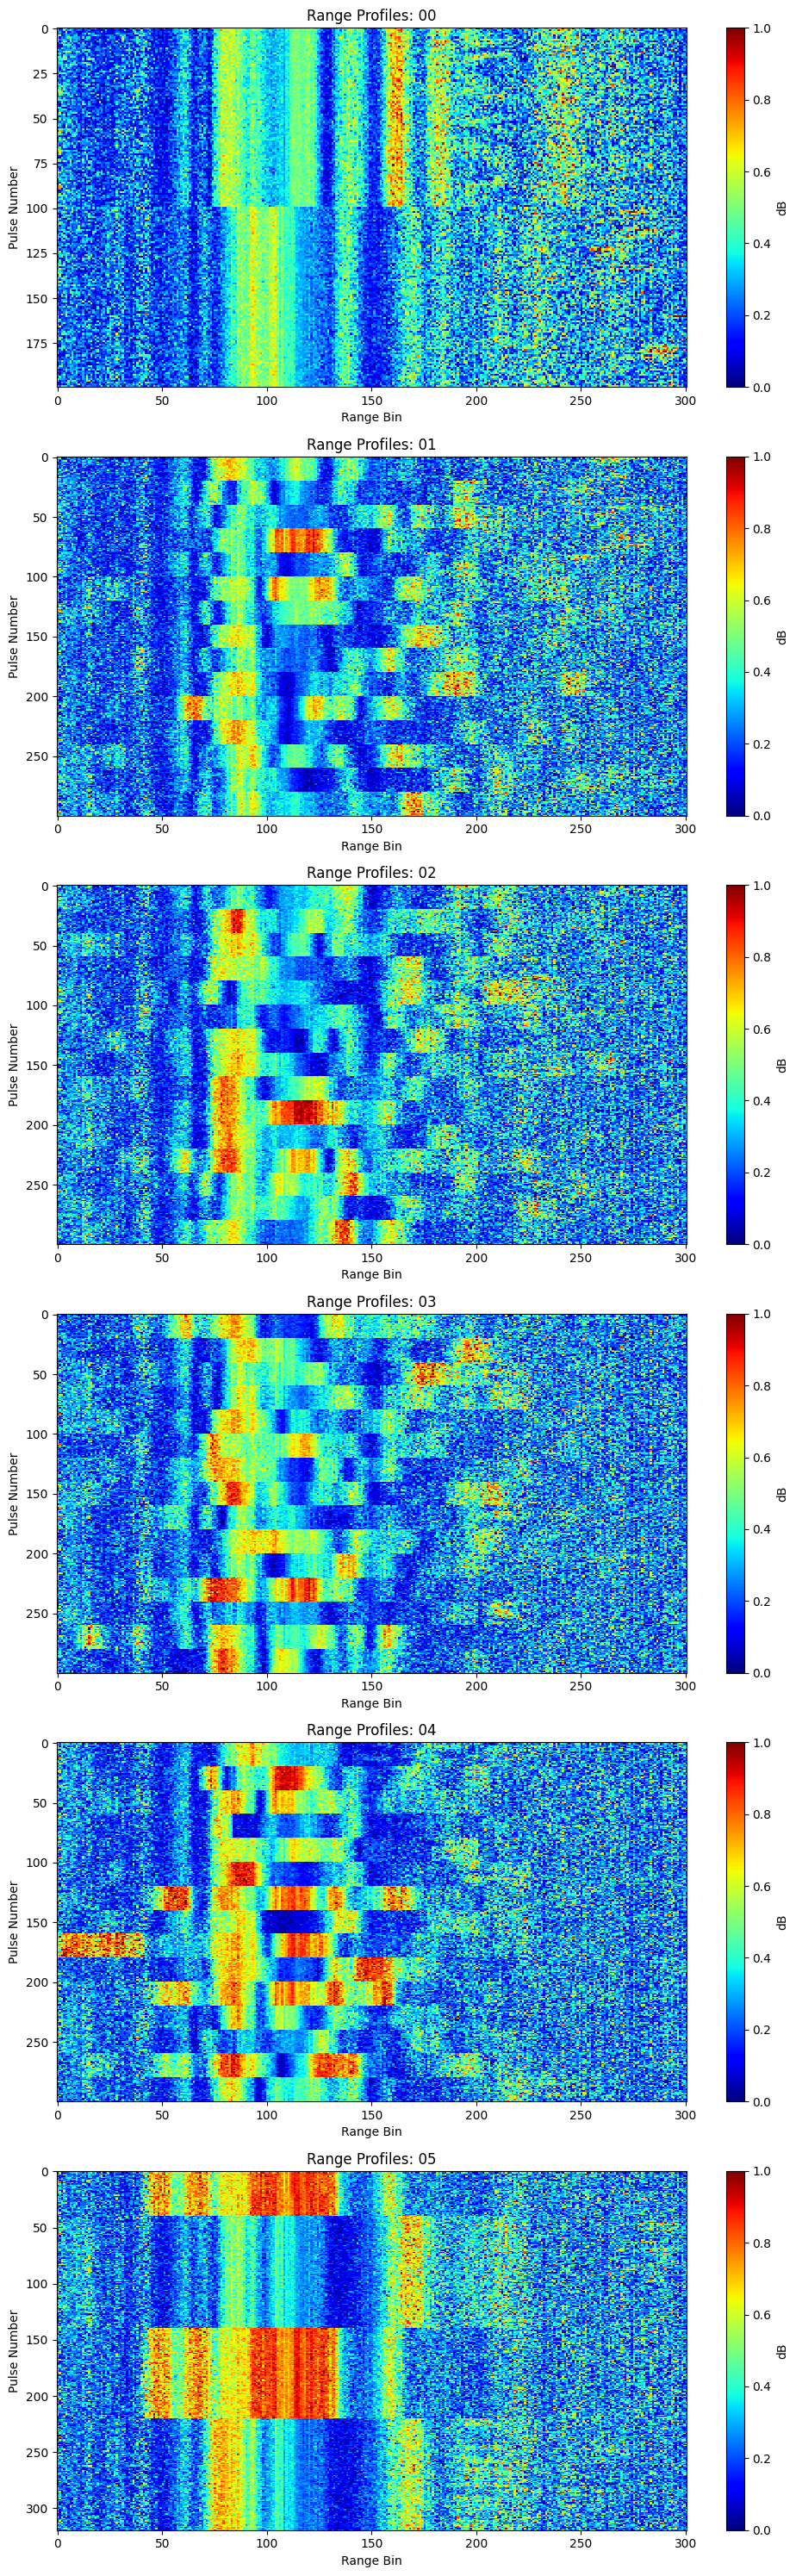

In [41]:
# 서브플롯 그리기
num_profiles = len(reshaped_data)
plt.figure(figsize=(10, 5 * num_profiles))

for idx, (key, profile) in enumerate(reshaped_data.items(), 1):
    plt.subplot(num_profiles, 1, idx)
    plt.imshow(profile, aspect='auto', cmap='jet', interpolation='none')
    # plt.imshow(np.abs(profile), aspect='auto', cmap='jet', interpolation='none')
    plt.colorbar(label="dB")
    plt.xlabel("Range Bin")
    plt.ylabel("Pulse Number")
    plt.title(f"Range Profiles: {key}")

plt.tight_layout()
plt.show()

In [24]:
# model = basemodel(len(range_fft_dict))

In [42]:
def make_dataset(data_dict):
    # x = list()
    y = list()
    x = None
    for key, data in data_dict.items():
        if x is None:
            x = data
        else:
            x = np.concatenate((x, data), axis = 0)
        for i in range(data.shape[0]):
            y.append(to_categorical(int(key), num_classes=len(data_dict)))
    print(x.shape)
    y = np.array(y)
    X_train, X_test, Y_train, Y_test = train_test_split(x, y, test_size=0.2, random_state=42)
    return X_train, X_test, Y_train, Y_test

In [43]:
# X_train, X_test, Y_train, Y_test = make_dataset(range_fft_dict)
# X_train, X_test  = 10 * np.log10(X_train), 10 * np.log10(X_test)
X_train, X_test, Y_train, Y_test = make_dataset(reshaped_data)
X_train, X_test = np.expand_dims(X_train, axis = 2), np.expand_dims(X_test, axis = 2)

(1720, 301)


X shape :  (1376, 301)
Model: "basemodel_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_5 (Dense)             multiple                  2416      
                                                                 
 batch_normalization_1 (Batc  multiple                 32        
 hNormalization)                                                 
                                                                 
 dense_6 (Dense)             multiple                  144       
                                                                 
 dense_7 (Dense)             multiple                  544       
                                                                 
 dense_8 (Dense)             multiple                  2112      
                                                                 
 dense_9 (Dense)             multiple                  390       
                                

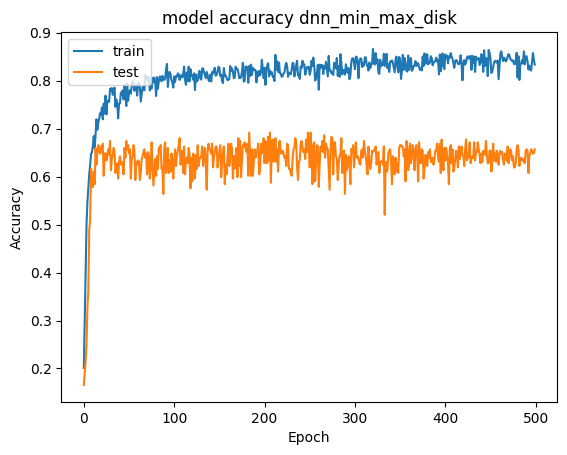

In [45]:
# base model
model = basemodel(len(reshaped_data))
history = train_dnn(model = model, X = np.squeeze(X_train, axis=2), Y = Y_train, test_X = np.squeeze(X_test, axis=2), test_Y = Y_test, cp_path = 'dnn_min_max_disk', Epoch=500)

In [46]:
# non_norm_model = non_norm(len(range_fft_dict))

# base model
# model = basemodel(len(range_fft_dict))

# Resnet
filter_in_list = [1, 32]
filter_out_list = [32, 64]
kernel_size = 3
# model = build_resnet(filter_in_list = filter_in_list, filter_out_list = filter_out_list, kernel_size = kernel_size, out_nums=len(reshaped_data))
model = Resnet(filter_in = filter_in_list, filters = filter_out_list, kernel_size = kernel_size, out_nums=len(reshaped_data))
history = train(model = model, X = X_train, Y = Y_train, test_X = X_test, test_Y = Y_test, cp_path = 'resnet_min_max_disk', Epoch=500)

X shape :  (1376, 301, 1)
Model: "resnet"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet_layer (ResnetLayer)  multiple                  24484     
                                                                 
 flatten (Flatten)           multiple                  0         
                                                                 
 dense_10 (Dense)            multiple                  2465920   
                                                                 
 dense_11 (Dense)            multiple                  8256      
                                                                 
 dense_12 (Dense)            multiple                  2080      
                                                                 
 dense_13 (Dense)            multiple                  198       
                                                                 
Total params: 2,500,938
Trainable 

2023-10-06 08:31:49.877247: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8401


41/43 [===========================>..] - ETA: 0s - loss: 1.3570 - accuracy: 0.5457 - categorical_crossentropy: 1.3570

INFO:tensorflow:Assets written to: ./model/resnet_min_max_disk/assets


INFO:tensorflow:Assets written to: ./model/resnet_min_max_disk/assets


43/43 [==============================] - 7s 85ms/step - loss: 1.3117 - accuracy: 0.5618 - categorical_crossentropy: 1.3117 - val_loss: 1.5052 - val_accuracy: 0.6395 - val_categorical_crossentropy: 1.5052
Epoch 2/500
43/43 [==============================] - 1s 17ms/step - loss: 0.1827 - accuracy: 0.9331 - categorical_crossentropy: 0.1827 - val_loss: 1.2990 - val_accuracy: 0.5814 - val_categorical_crossentropy: 1.2990
Epoch 3/500
41/43 [===========================>..] - ETA: 0s - loss: 0.0292 - accuracy: 0.9939 - categorical_crossentropy: 0.0292

INFO:tensorflow:Assets written to: ./model/resnet_min_max_disk/assets


INFO:tensorflow:Assets written to: ./model/resnet_min_max_disk/assets


43/43 [==============================] - 4s 86ms/step - loss: 0.0288 - accuracy: 0.9942 - categorical_crossentropy: 0.0288 - val_loss: 1.0074 - val_accuracy: 0.7442 - val_categorical_crossentropy: 1.0074
Epoch 4/500
41/43 [===========================>..] - ETA: 0s - loss: 0.0098 - accuracy: 0.9992 - categorical_crossentropy: 0.0098

INFO:tensorflow:Assets written to: ./model/resnet_min_max_disk/assets


INFO:tensorflow:Assets written to: ./model/resnet_min_max_disk/assets


43/43 [==============================] - 3s 80ms/step - loss: 0.0096 - accuracy: 0.9993 - categorical_crossentropy: 0.0096 - val_loss: 0.7380 - val_accuracy: 0.7849 - val_categorical_crossentropy: 0.7380
Epoch 5/500
41/43 [===========================>..] - ETA: 0s - loss: 0.0026 - accuracy: 1.0000 - categorical_crossentropy: 0.0026

INFO:tensorflow:Assets written to: ./model/resnet_min_max_disk/assets


INFO:tensorflow:Assets written to: ./model/resnet_min_max_disk/assets


43/43 [==============================] - 4s 87ms/step - loss: 0.0026 - accuracy: 1.0000 - categorical_crossentropy: 0.0026 - val_loss: 0.4277 - val_accuracy: 0.9186 - val_categorical_crossentropy: 0.4277
Epoch 6/500
42/43 [============================>.] - ETA: 0s - loss: 0.0015 - accuracy: 1.0000 - categorical_crossentropy: 0.0015

INFO:tensorflow:Assets written to: ./model/resnet_min_max_disk/assets


INFO:tensorflow:Assets written to: ./model/resnet_min_max_disk/assets


43/43 [==============================] - 3s 78ms/step - loss: 0.0015 - accuracy: 1.0000 - categorical_crossentropy: 0.0015 - val_loss: 0.2272 - val_accuracy: 0.9622 - val_categorical_crossentropy: 0.2272
Epoch 7/500
42/43 [============================>.] - ETA: 0s - loss: 8.8171e-04 - accuracy: 1.0000 - categorical_crossentropy: 8.8171e-04

INFO:tensorflow:Assets written to: ./model/resnet_min_max_disk/assets


INFO:tensorflow:Assets written to: ./model/resnet_min_max_disk/assets


43/43 [==============================] - 4s 90ms/step - loss: 8.7589e-04 - accuracy: 1.0000 - categorical_crossentropy: 8.7589e-04 - val_loss: 0.1321 - val_accuracy: 0.9797 - val_categorical_crossentropy: 0.1321
Epoch 8/500
41/43 [===========================>..] - ETA: 0s - loss: 0.0011 - accuracy: 1.0000 - categorical_crossentropy: 0.0011     

INFO:tensorflow:Assets written to: ./model/resnet_min_max_disk/assets


INFO:tensorflow:Assets written to: ./model/resnet_min_max_disk/assets


43/43 [==============================] - 3s 79ms/step - loss: 0.0031 - accuracy: 0.9993 - categorical_crossentropy: 0.0031 - val_loss: 0.0718 - val_accuracy: 0.9855 - val_categorical_crossentropy: 0.0718
Epoch 9/500
43/43 [==============================] - 1s 17ms/step - loss: 0.0165 - accuracy: 0.9956 - categorical_crossentropy: 0.0165 - val_loss: 0.1278 - val_accuracy: 0.9535 - val_categorical_crossentropy: 0.1278
Epoch 10/500
43/43 [==============================] - 1s 17ms/step - loss: 0.0026 - accuracy: 1.0000 - categorical_crossentropy: 0.0026 - val_loss: 0.0520 - val_accuracy: 0.9797 - val_categorical_crossentropy: 0.0520
Epoch 11/500
43/43 [==============================] - 1s 17ms/step - loss: 0.0013 - accuracy: 1.0000 - categorical_crossentropy: 0.0013 - val_loss: 0.0580 - val_accuracy: 0.9680 - val_categorical_crossentropy: 0.0580
Epoch 12/500
43/43 [==============================] - 1s 18ms/step - loss: 0.0014 - accuracy: 1.0000 - categorical_crossentropy: 0.0014 - val_loss

INFO:tensorflow:Assets written to: ./model/resnet_min_max_disk/assets


INFO:tensorflow:Assets written to: ./model/resnet_min_max_disk/assets


43/43 [==============================] - 4s 88ms/step - loss: 7.9964e-05 - accuracy: 1.0000 - categorical_crossentropy: 7.9964e-05 - val_loss: 0.0196 - val_accuracy: 0.9884 - val_categorical_crossentropy: 0.0196
Epoch 22/500
43/43 [==============================] - 1s 17ms/step - loss: 1.4996e-04 - accuracy: 1.0000 - categorical_crossentropy: 1.4996e-04 - val_loss: 0.0184 - val_accuracy: 0.9884 - val_categorical_crossentropy: 0.0184
Epoch 23/500
41/43 [===========================>..] - ETA: 0s - loss: 8.8822e-05 - accuracy: 1.0000 - categorical_crossentropy: 8.8822e-05

INFO:tensorflow:Assets written to: ./model/resnet_min_max_disk/assets


INFO:tensorflow:Assets written to: ./model/resnet_min_max_disk/assets


43/43 [==============================] - 3s 78ms/step - loss: 8.8349e-05 - accuracy: 1.0000 - categorical_crossentropy: 8.8349e-05 - val_loss: 0.0154 - val_accuracy: 0.9913 - val_categorical_crossentropy: 0.0154
Epoch 24/500
43/43 [==============================] - 1s 17ms/step - loss: 6.4586e-05 - accuracy: 1.0000 - categorical_crossentropy: 6.4586e-05 - val_loss: 0.0203 - val_accuracy: 0.9913 - val_categorical_crossentropy: 0.0203
Epoch 25/500
43/43 [==============================] - 1s 17ms/step - loss: 4.9076e-05 - accuracy: 1.0000 - categorical_crossentropy: 4.9076e-05 - val_loss: 0.0195 - val_accuracy: 0.9884 - val_categorical_crossentropy: 0.0195
Epoch 26/500
41/43 [===========================>..] - ETA: 0s - loss: 6.4827e-05 - accuracy: 1.0000 - categorical_crossentropy: 6.4827e-05

INFO:tensorflow:Assets written to: ./model/resnet_min_max_disk/assets


INFO:tensorflow:Assets written to: ./model/resnet_min_max_disk/assets


43/43 [==============================] - 4s 89ms/step - loss: 6.3695e-05 - accuracy: 1.0000 - categorical_crossentropy: 6.3695e-05 - val_loss: 0.0155 - val_accuracy: 0.9942 - val_categorical_crossentropy: 0.0155
Epoch 27/500
43/43 [==============================] - 1s 17ms/step - loss: 4.2547e-05 - accuracy: 1.0000 - categorical_crossentropy: 4.2547e-05 - val_loss: 0.0173 - val_accuracy: 0.9913 - val_categorical_crossentropy: 0.0173
Epoch 28/500
43/43 [==============================] - 1s 18ms/step - loss: 4.9982e-05 - accuracy: 1.0000 - categorical_crossentropy: 4.9982e-05 - val_loss: 0.0169 - val_accuracy: 0.9913 - val_categorical_crossentropy: 0.0169
Epoch 29/500
43/43 [==============================] - 1s 18ms/step - loss: 3.8461e-05 - accuracy: 1.0000 - categorical_crossentropy: 3.8461e-05 - val_loss: 0.0183 - val_accuracy: 0.9884 - val_categorical_crossentropy: 0.0183
Epoch 30/500
43/43 [==============================] - 1s 18ms/step - loss: 4.3420e-05 - accuracy: 1.0000 - catego

INFO:tensorflow:Assets written to: ./model/resnet_min_max_disk/assets


INFO:tensorflow:Assets written to: ./model/resnet_min_max_disk/assets


43/43 [==============================] - 3s 80ms/step - loss: 1.8048e-05 - accuracy: 1.0000 - categorical_crossentropy: 1.8048e-05 - val_loss: 0.0107 - val_accuracy: 0.9971 - val_categorical_crossentropy: 0.0107
Epoch 52/500
43/43 [==============================] - 1s 17ms/step - loss: 1.1878e-05 - accuracy: 1.0000 - categorical_crossentropy: 1.1878e-05 - val_loss: 0.0117 - val_accuracy: 0.9942 - val_categorical_crossentropy: 0.0117
Epoch 53/500
43/43 [==============================] - 1s 17ms/step - loss: 1.4811e-05 - accuracy: 1.0000 - categorical_crossentropy: 1.4811e-05 - val_loss: 0.0114 - val_accuracy: 0.9942 - val_categorical_crossentropy: 0.0114
Epoch 54/500
43/43 [==============================] - 1s 17ms/step - loss: 1.0099e-05 - accuracy: 1.0000 - categorical_crossentropy: 1.0099e-05 - val_loss: 0.0116 - val_accuracy: 0.9942 - val_categorical_crossentropy: 0.0116
Epoch 55/500
43/43 [==============================] - 1s 16ms/step - loss: 1.0374e-05 - accuracy: 1.0000 - catego

INFO:tensorflow:Assets written to: ./model/resnet_min_max_disk/assets


INFO:tensorflow:Assets written to: ./model/resnet_min_max_disk/assets


43/43 [==============================] - 4s 88ms/step - loss: 7.5223e-06 - accuracy: 1.0000 - categorical_crossentropy: 7.5223e-06 - val_loss: 0.0080 - val_accuracy: 1.0000 - val_categorical_crossentropy: 0.0080
Epoch 81/500
43/43 [==============================] - 1s 17ms/step - loss: 3.5508e-06 - accuracy: 1.0000 - categorical_crossentropy: 3.5508e-06 - val_loss: 0.0086 - val_accuracy: 0.9971 - val_categorical_crossentropy: 0.0086
Epoch 82/500
43/43 [==============================] - 1s 17ms/step - loss: 3.6100e-06 - accuracy: 1.0000 - categorical_crossentropy: 3.6100e-06 - val_loss: 0.0092 - val_accuracy: 0.9971 - val_categorical_crossentropy: 0.0092
Epoch 83/500
43/43 [==============================] - 1s 17ms/step - loss: 3.3984e-06 - accuracy: 1.0000 - categorical_crossentropy: 3.3984e-06 - val_loss: 0.0092 - val_accuracy: 0.9971 - val_categorical_crossentropy: 0.0092
Epoch 84/500
43/43 [==============================] - 1s 17ms/step - loss: 3.2934e-06 - accuracy: 1.0000 - catego

X shape :  (3264, 301, 1)
Model: "resnet_regression_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_9 (Normalizat  multiple                 3         
 ion)                                                            
                                                                 
 resnet_layer_9 (ResnetLayer  multiple                 24484     
 )                                                               
                                                                 
 flatten_9 (Flatten)         multiple                  0         
                                                                 
 dense_36 (Dense)            multiple                  2465920   
                                                                 
 dense_37 (Dense)            multiple                  8256      
                                                                 
 dense_38 (Dense)    

INFO:tensorflow:Assets written to: ./model/resnet_range_fft_regression/assets


INFO:tensorflow:Assets written to: ./model/resnet_range_fft_regression/assets


102/102 [==============================] - 5s 44ms/step - loss: 2401.3000 - mae: 12.0921 - mse: 2401.3000 - val_loss: 15.8238 - val_mae: 3.2392 - val_mse: 15.8238
Epoch 2/500
101/102 [============================>.] - ETA: 0s - loss: 14.6274 - mae: 3.0670 - mse: 14.6274

INFO:tensorflow:Assets written to: ./model/resnet_range_fft_regression/assets


INFO:tensorflow:Assets written to: ./model/resnet_range_fft_regression/assets


102/102 [==============================] - 5s 47ms/step - loss: 14.5460 - mae: 3.0572 - mse: 14.5460 - val_loss: 14.5178 - val_mae: 3.0693 - val_mse: 14.5178
Epoch 3/500
102/102 [==============================] - 2s 15ms/step - loss: 19.7360 - mae: 3.5608 - mse: 19.7360 - val_loss: 19.1450 - val_mae: 3.6171 - val_mse: 19.1450
Epoch 4/500
102/102 [==============================] - ETA: 0s - loss: 13.9346 - mae: 2.9841 - mse: 13.9346

INFO:tensorflow:Assets written to: ./model/resnet_range_fft_regression/assets


INFO:tensorflow:Assets written to: ./model/resnet_range_fft_regression/assets


102/102 [==============================] - 4s 42ms/step - loss: 13.9346 - mae: 2.9841 - mse: 13.9346 - val_loss: 12.4459 - val_mae: 2.8901 - val_mse: 12.4459
Epoch 5/500
102/102 [==============================] - 2s 16ms/step - loss: 20.8219 - mae: 3.6790 - mse: 20.8219 - val_loss: 16.5947 - val_mae: 3.3989 - val_mse: 16.5947
Epoch 6/500
102/102 [==============================] - 2s 15ms/step - loss: 15.7487 - mae: 3.1919 - mse: 15.7487 - val_loss: 27.3781 - val_mae: 4.4048 - val_mse: 27.3781
Epoch 7/500
102/102 [==============================] - 2s 15ms/step - loss: 20.9155 - mae: 3.6465 - mse: 20.9155 - val_loss: 30.0095 - val_mae: 4.6575 - val_mse: 30.0095
Epoch 8/500
102/102 [==============================] - 2s 15ms/step - loss: 13.3131 - mae: 2.9068 - mse: 13.3131 - val_loss: 13.7295 - val_mae: 3.0526 - val_mse: 13.7295
Epoch 9/500
102/102 [==============================] - 2s 15ms/step - loss: 14.2284 - mae: 3.0169 - mse: 14.2284 - val_loss: 13.9482 - val_mae: 2.9976 - val_mse: 

INFO:tensorflow:Assets written to: ./model/resnet_range_fft_regression/assets


INFO:tensorflow:Assets written to: ./model/resnet_range_fft_regression/assets


102/102 [==============================] - 5s 48ms/step - loss: 12.6945 - mae: 2.8490 - mse: 12.6945 - val_loss: 8.9177 - val_mae: 2.4114 - val_mse: 8.9177
Epoch 11/500
102/102 [==============================] - 2s 16ms/step - loss: 15.0984 - mae: 3.1006 - mse: 15.0984 - val_loss: 20.8991 - val_mae: 3.8295 - val_mse: 20.8991
Epoch 12/500
100/102 [============================>.] - ETA: 0s - loss: 12.0503 - mae: 2.7765 - mse: 12.0503

INFO:tensorflow:Assets written to: ./model/resnet_range_fft_regression/assets


INFO:tensorflow:Assets written to: ./model/resnet_range_fft_regression/assets


102/102 [==============================] - 4s 42ms/step - loss: 11.9842 - mae: 2.7678 - mse: 11.9842 - val_loss: 7.7669 - val_mae: 2.2147 - val_mse: 7.7669
Epoch 13/500
100/102 [============================>.] - ETA: 0s - loss: 12.7857 - mae: 2.8585 - mse: 12.7857

INFO:tensorflow:Assets written to: ./model/resnet_range_fft_regression/assets


INFO:tensorflow:Assets written to: ./model/resnet_range_fft_regression/assets


102/102 [==============================] - 4s 42ms/step - loss: 12.7118 - mae: 2.8511 - mse: 12.7118 - val_loss: 7.1334 - val_mae: 2.1387 - val_mse: 7.1334
Epoch 14/500
102/102 [==============================] - 2s 16ms/step - loss: 12.6922 - mae: 2.8788 - mse: 12.6922 - val_loss: 9.9306 - val_mae: 2.5714 - val_mse: 9.9306
Epoch 15/500
102/102 [==============================] - 2s 16ms/step - loss: 15.4454 - mae: 3.1421 - mse: 15.4454 - val_loss: 16.1398 - val_mae: 3.3188 - val_mse: 16.1398
Epoch 16/500
102/102 [==============================] - 2s 16ms/step - loss: 7.7016 - mae: 2.2122 - mse: 7.7016 - val_loss: 8.9553 - val_mae: 2.4690 - val_mse: 8.9553
Epoch 17/500
101/102 [============================>.] - ETA: 0s - loss: 7.6659 - mae: 2.1861 - mse: 7.6659

INFO:tensorflow:Assets written to: ./model/resnet_range_fft_regression/assets


INFO:tensorflow:Assets written to: ./model/resnet_range_fft_regression/assets


102/102 [==============================] - 5s 48ms/step - loss: 7.6857 - mae: 2.1883 - mse: 7.6857 - val_loss: 5.0222 - val_mae: 1.7685 - val_mse: 5.0222
Epoch 18/500
100/102 [============================>.] - ETA: 0s - loss: 5.4965 - mae: 1.8478 - mse: 5.4965

INFO:tensorflow:Assets written to: ./model/resnet_range_fft_regression/assets


INFO:tensorflow:Assets written to: ./model/resnet_range_fft_regression/assets


102/102 [==============================] - 4s 42ms/step - loss: 5.5225 - mae: 1.8507 - mse: 5.5225 - val_loss: 4.8343 - val_mae: 1.7480 - val_mse: 4.8343
Epoch 19/500
101/102 [============================>.] - ETA: 0s - loss: 7.0941 - mae: 2.1085 - mse: 7.0941

INFO:tensorflow:Assets written to: ./model/resnet_range_fft_regression/assets


INFO:tensorflow:Assets written to: ./model/resnet_range_fft_regression/assets


102/102 [==============================] - 4s 41ms/step - loss: 7.1015 - mae: 2.1081 - mse: 7.1015 - val_loss: 4.7884 - val_mae: 1.7508 - val_mse: 4.7884
Epoch 20/500
101/102 [============================>.] - ETA: 0s - loss: 6.9637 - mae: 2.0916 - mse: 6.9637

INFO:tensorflow:Assets written to: ./model/resnet_range_fft_regression/assets


INFO:tensorflow:Assets written to: ./model/resnet_range_fft_regression/assets


102/102 [==============================] - 5s 48ms/step - loss: 6.9354 - mae: 2.0877 - mse: 6.9354 - val_loss: 4.6044 - val_mae: 1.7194 - val_mse: 4.6044
Epoch 21/500
102/102 [==============================] - 2s 15ms/step - loss: 6.0443 - mae: 1.9518 - mse: 6.0443 - val_loss: 6.9587 - val_mae: 2.1764 - val_mse: 6.9587
Epoch 22/500
 98/102 [===========================>..] - ETA: 0s - loss: 6.0539 - mae: 1.9375 - mse: 6.0539

INFO:tensorflow:Assets written to: ./model/resnet_range_fft_regression/assets


INFO:tensorflow:Assets written to: ./model/resnet_range_fft_regression/assets


102/102 [==============================] - 4s 42ms/step - loss: 5.9889 - mae: 1.9294 - mse: 5.9889 - val_loss: 4.0048 - val_mae: 1.5618 - val_mse: 4.0048
Epoch 23/500
102/102 [==============================] - 1s 14ms/step - loss: 5.9573 - mae: 1.9441 - mse: 5.9573 - val_loss: 4.0735 - val_mae: 1.5957 - val_mse: 4.0735
Epoch 24/500
102/102 [==============================] - ETA: 0s - loss: 4.3689 - mae: 1.6432 - mse: 4.3689

INFO:tensorflow:Assets written to: ./model/resnet_range_fft_regression/assets


INFO:tensorflow:Assets written to: ./model/resnet_range_fft_regression/assets


102/102 [==============================] - 5s 47ms/step - loss: 4.3689 - mae: 1.6432 - mse: 4.3689 - val_loss: 3.8140 - val_mae: 1.5498 - val_mse: 3.8140
Epoch 25/500
102/102 [==============================] - ETA: 0s - loss: 5.1409 - mae: 1.7960 - mse: 5.1409

INFO:tensorflow:Assets written to: ./model/resnet_range_fft_regression/assets


INFO:tensorflow:Assets written to: ./model/resnet_range_fft_regression/assets


102/102 [==============================] - 4s 42ms/step - loss: 5.1409 - mae: 1.7960 - mse: 5.1409 - val_loss: 3.7635 - val_mae: 1.5171 - val_mse: 3.7635
Epoch 26/500
102/102 [==============================] - 2s 15ms/step - loss: 3.5220 - mae: 1.4718 - mse: 3.5220 - val_loss: 4.4010 - val_mae: 1.6169 - val_mse: 4.4010
Epoch 27/500
102/102 [==============================] - 2s 15ms/step - loss: 4.0959 - mae: 1.5994 - mse: 4.0959 - val_loss: 5.0757 - val_mae: 1.7706 - val_mse: 5.0757
Epoch 28/500
102/102 [==============================] - 2s 16ms/step - loss: 3.5920 - mae: 1.4807 - mse: 3.5920 - val_loss: 4.2598 - val_mae: 1.6570 - val_mse: 4.2598
Epoch 29/500
102/102 [==============================] - 2s 15ms/step - loss: 3.3147 - mae: 1.4139 - mse: 3.3147 - val_loss: 3.8176 - val_mae: 1.5297 - val_mse: 3.8176
Epoch 30/500
102/102 [==============================] - 2s 15ms/step - loss: 2.9702 - mae: 1.3712 - mse: 2.9702 - val_loss: 5.2518 - val_mae: 1.7995 - val_mse: 5.2518
Epoch 31/50

INFO:tensorflow:Assets written to: ./model/resnet_range_fft_regression/assets


INFO:tensorflow:Assets written to: ./model/resnet_range_fft_regression/assets


102/102 [==============================] - 4s 42ms/step - loss: 3.1755 - mae: 1.4132 - mse: 3.1755 - val_loss: 2.8517 - val_mae: 1.3033 - val_mse: 2.8517
Epoch 32/500
102/102 [==============================] - 2s 15ms/step - loss: 4.2045 - mae: 1.6010 - mse: 4.2045 - val_loss: 3.3619 - val_mae: 1.4245 - val_mse: 3.3619
Epoch 33/500
102/102 [==============================] - 2s 15ms/step - loss: 26.6353 - mae: 2.2073 - mse: 26.6353 - val_loss: 52.5412 - val_mae: 6.1846 - val_mse: 52.5412
Epoch 34/500
102/102 [==============================] - 2s 15ms/step - loss: 16.3630 - mae: 3.1866 - mse: 16.3630 - val_loss: 7.4690 - val_mae: 2.2107 - val_mse: 7.4690
Epoch 35/500
102/102 [==============================] - 2s 15ms/step - loss: 7.1629 - mae: 2.1333 - mse: 7.1629 - val_loss: 5.9703 - val_mae: 1.9535 - val_mse: 5.9703
Epoch 36/500
102/102 [==============================] - 2s 15ms/step - loss: 5.6321 - mae: 1.8873 - mse: 5.6321 - val_loss: 5.5855 - val_mae: 1.8912 - val_mse: 5.5855
Epoch

INFO:tensorflow:Assets written to: ./model/resnet_range_fft_regression/assets


INFO:tensorflow:Assets written to: ./model/resnet_range_fft_regression/assets


102/102 [==============================] - 5s 48ms/step - loss: 2.3480 - mae: 1.1718 - mse: 2.3480 - val_loss: 2.7269 - val_mae: 1.2867 - val_mse: 2.7269
Epoch 47/500
102/102 [==============================] - 2s 16ms/step - loss: 2.4970 - mae: 1.2140 - mse: 2.4970 - val_loss: 2.7894 - val_mae: 1.3054 - val_mse: 2.7894
Epoch 48/500
102/102 [==============================] - 2s 16ms/step - loss: 1.8136 - mae: 1.0415 - mse: 1.8136 - val_loss: 2.7935 - val_mae: 1.3186 - val_mse: 2.7935
Epoch 49/500
100/102 [============================>.] - ETA: 0s - loss: 1.7052 - mae: 1.0098 - mse: 1.7052

INFO:tensorflow:Assets written to: ./model/resnet_range_fft_regression/assets


INFO:tensorflow:Assets written to: ./model/resnet_range_fft_regression/assets


102/102 [==============================] - 4s 42ms/step - loss: 1.7064 - mae: 1.0097 - mse: 1.7064 - val_loss: 2.5622 - val_mae: 1.2276 - val_mse: 2.5622
Epoch 50/500
102/102 [==============================] - 2s 15ms/step - loss: 1.5787 - mae: 0.9696 - mse: 1.5787 - val_loss: 2.7976 - val_mae: 1.2829 - val_mse: 2.7976
Epoch 51/500
102/102 [==============================] - 2s 15ms/step - loss: 1.5701 - mae: 0.9673 - mse: 1.5701 - val_loss: 3.6444 - val_mae: 1.5163 - val_mse: 3.6444
Epoch 52/500
100/102 [============================>.] - ETA: 0s - loss: 1.4416 - mae: 0.9162 - mse: 1.4416

INFO:tensorflow:Assets written to: ./model/resnet_range_fft_regression/assets


INFO:tensorflow:Assets written to: ./model/resnet_range_fft_regression/assets


102/102 [==============================] - 5s 46ms/step - loss: 1.4390 - mae: 0.9150 - mse: 1.4390 - val_loss: 2.3186 - val_mae: 1.1745 - val_mse: 2.3186
Epoch 53/500
100/102 [============================>.] - ETA: 0s - loss: 1.3655 - mae: 0.8975 - mse: 1.3655

INFO:tensorflow:Assets written to: ./model/resnet_range_fft_regression/assets


INFO:tensorflow:Assets written to: ./model/resnet_range_fft_regression/assets


102/102 [==============================] - 4s 42ms/step - loss: 1.3667 - mae: 0.8983 - mse: 1.3667 - val_loss: 2.1679 - val_mae: 1.1323 - val_mse: 2.1679
Epoch 54/500
100/102 [============================>.] - ETA: 0s - loss: 1.3354 - mae: 0.8857 - mse: 1.3354

INFO:tensorflow:Assets written to: ./model/resnet_range_fft_regression/assets


INFO:tensorflow:Assets written to: ./model/resnet_range_fft_regression/assets


102/102 [==============================] - 4s 42ms/step - loss: 1.3315 - mae: 0.8827 - mse: 1.3315 - val_loss: 2.0915 - val_mae: 1.1103 - val_mse: 2.0915
Epoch 55/500
102/102 [==============================] - ETA: 0s - loss: 1.2466 - mae: 0.8635 - mse: 1.2466

INFO:tensorflow:Assets written to: ./model/resnet_range_fft_regression/assets


INFO:tensorflow:Assets written to: ./model/resnet_range_fft_regression/assets


102/102 [==============================] - 5s 48ms/step - loss: 1.2466 - mae: 0.8635 - mse: 1.2466 - val_loss: 2.0906 - val_mae: 1.1227 - val_mse: 2.0906
Epoch 56/500
102/102 [==============================] - 2s 15ms/step - loss: 1.1839 - mae: 0.8395 - mse: 1.1839 - val_loss: 2.0975 - val_mae: 1.0992 - val_mse: 2.0975
Epoch 57/500
102/102 [==============================] - 2s 15ms/step - loss: 1.1663 - mae: 0.8272 - mse: 1.1663 - val_loss: 2.1728 - val_mae: 1.1209 - val_mse: 2.1728
Epoch 58/500
 99/102 [============================>.] - ETA: 0s - loss: 1.0570 - mae: 0.7958 - mse: 1.0570

INFO:tensorflow:Assets written to: ./model/resnet_range_fft_regression/assets


INFO:tensorflow:Assets written to: ./model/resnet_range_fft_regression/assets


102/102 [==============================] - 4s 41ms/step - loss: 1.0597 - mae: 0.7978 - mse: 1.0597 - val_loss: 2.0608 - val_mae: 1.0786 - val_mse: 2.0608
Epoch 59/500
102/102 [==============================] - ETA: 0s - loss: 1.0617 - mae: 0.7927 - mse: 1.0617

INFO:tensorflow:Assets written to: ./model/resnet_range_fft_regression/assets


INFO:tensorflow:Assets written to: ./model/resnet_range_fft_regression/assets


102/102 [==============================] - 5s 46ms/step - loss: 1.0617 - mae: 0.7927 - mse: 1.0617 - val_loss: 1.9994 - val_mae: 1.0537 - val_mse: 1.9994
Epoch 60/500
 99/102 [============================>.] - ETA: 0s - loss: 1.0775 - mae: 0.8073 - mse: 1.0775

INFO:tensorflow:Assets written to: ./model/resnet_range_fft_regression/assets


INFO:tensorflow:Assets written to: ./model/resnet_range_fft_regression/assets


102/102 [==============================] - 4s 42ms/step - loss: 1.0783 - mae: 0.8048 - mse: 1.0783 - val_loss: 1.8571 - val_mae: 1.0353 - val_mse: 1.8571
Epoch 61/500
102/102 [==============================] - 2s 15ms/step - loss: 0.9244 - mae: 0.7421 - mse: 0.9244 - val_loss: 2.1956 - val_mae: 1.0946 - val_mse: 2.1956
Epoch 62/500
102/102 [==============================] - 2s 16ms/step - loss: 1.0096 - mae: 0.7771 - mse: 1.0096 - val_loss: 1.9496 - val_mae: 1.0115 - val_mse: 1.9496
Epoch 63/500
102/102 [==============================] - 2s 16ms/step - loss: 0.8798 - mae: 0.7230 - mse: 0.8798 - val_loss: 2.0643 - val_mae: 1.0614 - val_mse: 2.0643
Epoch 64/500
101/102 [============================>.] - ETA: 0s - loss: 1.0394 - mae: 0.7936 - mse: 1.0394

INFO:tensorflow:Assets written to: ./model/resnet_range_fft_regression/assets


INFO:tensorflow:Assets written to: ./model/resnet_range_fft_regression/assets


102/102 [==============================] - 4s 42ms/step - loss: 1.0355 - mae: 0.7919 - mse: 1.0355 - val_loss: 1.7620 - val_mae: 0.9954 - val_mse: 1.7620
Epoch 65/500
102/102 [==============================] - 2s 16ms/step - loss: 0.7959 - mae: 0.6950 - mse: 0.7959 - val_loss: 1.7645 - val_mae: 0.9718 - val_mse: 1.7645
Epoch 66/500
102/102 [==============================] - 2s 15ms/step - loss: 0.7371 - mae: 0.6630 - mse: 0.7371 - val_loss: 1.9203 - val_mae: 1.0212 - val_mse: 1.9203
Epoch 67/500
102/102 [==============================] - 2s 15ms/step - loss: 0.6738 - mae: 0.6340 - mse: 0.6738 - val_loss: 2.4361 - val_mae: 1.1748 - val_mse: 2.4361
Epoch 68/500
102/102 [==============================] - 2s 15ms/step - loss: 0.6948 - mae: 0.6504 - mse: 0.6948 - val_loss: 1.9890 - val_mae: 1.0691 - val_mse: 1.9890
Epoch 69/500
102/102 [==============================] - 2s 15ms/step - loss: 0.6613 - mae: 0.6334 - mse: 0.6613 - val_loss: 1.7711 - val_mae: 0.9445 - val_mse: 1.7711
Epoch 70/50

INFO:tensorflow:Assets written to: ./model/resnet_range_fft_regression/assets


INFO:tensorflow:Assets written to: ./model/resnet_range_fft_regression/assets


102/102 [==============================] - 5s 48ms/step - loss: 0.5873 - mae: 0.6016 - mse: 0.5873 - val_loss: 1.6692 - val_mae: 0.9076 - val_mse: 1.6692
Epoch 72/500
102/102 [==============================] - 2s 16ms/step - loss: 0.5919 - mae: 0.6010 - mse: 0.5919 - val_loss: 1.7299 - val_mae: 0.9568 - val_mse: 1.7299
Epoch 73/500
102/102 [==============================] - 2s 15ms/step - loss: 0.5886 - mae: 0.5914 - mse: 0.5886 - val_loss: 1.9116 - val_mae: 0.9903 - val_mse: 1.9116
Epoch 74/500
102/102 [==============================] - 2s 15ms/step - loss: 0.8842 - mae: 0.7214 - mse: 0.8842 - val_loss: 1.9108 - val_mae: 0.9964 - val_mse: 1.9108
Epoch 75/500
 99/102 [============================>.] - ETA: 0s - loss: 0.8336 - mae: 0.7022 - mse: 0.8336

INFO:tensorflow:Assets written to: ./model/resnet_range_fft_regression/assets


INFO:tensorflow:Assets written to: ./model/resnet_range_fft_regression/assets


102/102 [==============================] - 4s 41ms/step - loss: 0.8333 - mae: 0.7012 - mse: 0.8333 - val_loss: 1.6159 - val_mae: 0.9169 - val_mse: 1.6159
Epoch 76/500
102/102 [==============================] - 2s 16ms/step - loss: 1.1816 - mae: 0.6743 - mse: 1.1816 - val_loss: 40.7677 - val_mae: 5.5069 - val_mse: 40.7677
Epoch 77/500
102/102 [==============================] - 2s 16ms/step - loss: 5.9906 - mae: 1.7720 - mse: 5.9906 - val_loss: 2.9087 - val_mae: 1.3010 - val_mse: 2.9087
Epoch 78/500
102/102 [==============================] - 2s 15ms/step - loss: 1.4412 - mae: 0.9344 - mse: 1.4412 - val_loss: 2.4674 - val_mae: 1.1493 - val_mse: 2.4674
Epoch 79/500
102/102 [==============================] - 2s 16ms/step - loss: 0.9602 - mae: 0.7657 - mse: 0.9602 - val_loss: 1.9764 - val_mae: 1.0591 - val_mse: 1.9764
Epoch 80/500
102/102 [==============================] - 2s 15ms/step - loss: 0.8893 - mae: 0.7343 - mse: 0.8893 - val_loss: 3.2197 - val_mae: 1.4053 - val_mse: 3.2197
Epoch 81/

INFO:tensorflow:Assets written to: ./model/resnet_range_fft_regression/assets


INFO:tensorflow:Assets written to: ./model/resnet_range_fft_regression/assets


102/102 [==============================] - 4s 42ms/step - loss: 0.3521 - mae: 0.4658 - mse: 0.3521 - val_loss: 1.5476 - val_mae: 0.8887 - val_mse: 1.5476
Epoch 91/500
102/102 [==============================] - 2s 15ms/step - loss: 0.3538 - mae: 0.4625 - mse: 0.3538 - val_loss: 1.6913 - val_mae: 0.9244 - val_mse: 1.6913
Epoch 92/500
102/102 [==============================] - 2s 15ms/step - loss: 0.3257 - mae: 0.4453 - mse: 0.3257 - val_loss: 1.6662 - val_mae: 0.9235 - val_mse: 1.6662
Epoch 93/500
102/102 [==============================] - 2s 15ms/step - loss: 0.2738 - mae: 0.4121 - mse: 0.2738 - val_loss: 1.6223 - val_mae: 0.8911 - val_mse: 1.6223
Epoch 94/500
102/102 [==============================] - 2s 15ms/step - loss: 0.3095 - mae: 0.4347 - mse: 0.3095 - val_loss: 1.6591 - val_mae: 0.9007 - val_mse: 1.6591
Epoch 95/500
102/102 [==============================] - 2s 15ms/step - loss: 0.2589 - mae: 0.3966 - mse: 0.2589 - val_loss: 1.6342 - val_mae: 0.9429 - val_mse: 1.6342
Epoch 96/50

INFO:tensorflow:Assets written to: ./model/resnet_range_fft_regression/assets


INFO:tensorflow:Assets written to: ./model/resnet_range_fft_regression/assets


102/102 [==============================] - 5s 48ms/step - loss: 0.2346 - mae: 0.3805 - mse: 0.2346 - val_loss: 1.4538 - val_mae: 0.8504 - val_mse: 1.4538
Epoch 97/500
102/102 [==============================] - 2s 15ms/step - loss: 0.2443 - mae: 0.3851 - mse: 0.2443 - val_loss: 1.5887 - val_mae: 0.9225 - val_mse: 1.5887
Epoch 98/500
102/102 [==============================] - 2s 15ms/step - loss: 0.2987 - mae: 0.4243 - mse: 0.2987 - val_loss: 1.7635 - val_mae: 0.9390 - val_mse: 1.7635
Epoch 99/500
102/102 [==============================] - 2s 15ms/step - loss: 0.2681 - mae: 0.4074 - mse: 0.2681 - val_loss: 1.5148 - val_mae: 0.8814 - val_mse: 1.5148
Epoch 100/500
102/102 [==============================] - 2s 16ms/step - loss: 0.2506 - mae: 0.3946 - mse: 0.2506 - val_loss: 2.2511 - val_mae: 1.1555 - val_mse: 2.2511
Epoch 101/500
102/102 [==============================] - 2s 15ms/step - loss: 0.3056 - mae: 0.4335 - mse: 0.3056 - val_loss: 1.5900 - val_mae: 0.8766 - val_mse: 1.5900
Epoch 102

INFO:tensorflow:Assets written to: ./model/resnet_range_fft_regression/assets


INFO:tensorflow:Assets written to: ./model/resnet_range_fft_regression/assets


102/102 [==============================] - 4s 42ms/step - loss: 0.2063 - mae: 0.3562 - mse: 0.2063 - val_loss: 1.4153 - val_mae: 0.8254 - val_mse: 1.4153
Epoch 115/500
102/102 [==============================] - 2s 15ms/step - loss: 0.2116 - mae: 0.3539 - mse: 0.2116 - val_loss: 1.4323 - val_mae: 0.8305 - val_mse: 1.4323
Epoch 116/500
102/102 [==============================] - 1s 15ms/step - loss: 0.1794 - mae: 0.3293 - mse: 0.1794 - val_loss: 1.7712 - val_mae: 0.9259 - val_mse: 1.7712
Epoch 117/500
102/102 [==============================] - 1s 14ms/step - loss: 0.2000 - mae: 0.3515 - mse: 0.2000 - val_loss: 1.5928 - val_mae: 0.8922 - val_mse: 1.5928
Epoch 118/500
102/102 [==============================] - 2s 16ms/step - loss: 0.1193 - mae: 0.2711 - mse: 0.1193 - val_loss: 1.5743 - val_mae: 0.8954 - val_mse: 1.5743
Epoch 119/500
102/102 [==============================] - 2s 16ms/step - loss: 0.1577 - mae: 0.3078 - mse: 0.1577 - val_loss: 1.5170 - val_mae: 0.8411 - val_mse: 1.5170
Epoch 

INFO:tensorflow:Assets written to: ./model/resnet_range_fft_regression/assets


INFO:tensorflow:Assets written to: ./model/resnet_range_fft_regression/assets


102/102 [==============================] - 5s 47ms/step - loss: 0.1364 - mae: 0.2925 - mse: 0.1364 - val_loss: 1.3583 - val_mae: 0.8101 - val_mse: 1.3583
Epoch 128/500
102/102 [==============================] - 2s 16ms/step - loss: 0.0998 - mae: 0.2478 - mse: 0.0998 - val_loss: 1.3738 - val_mae: 0.8034 - val_mse: 1.3738
Epoch 129/500
 99/102 [============================>.] - ETA: 0s - loss: 0.0893 - mae: 0.2330 - mse: 0.0893

INFO:tensorflow:Assets written to: ./model/resnet_range_fft_regression/assets


INFO:tensorflow:Assets written to: ./model/resnet_range_fft_regression/assets


102/102 [==============================] - 5s 45ms/step - loss: 0.0892 - mae: 0.2329 - mse: 0.0892 - val_loss: 1.3357 - val_mae: 0.8181 - val_mse: 1.3357
Epoch 130/500
102/102 [==============================] - 2s 15ms/step - loss: 0.1050 - mae: 0.2560 - mse: 0.1050 - val_loss: 1.3729 - val_mae: 0.8145 - val_mse: 1.3729
Epoch 131/500
102/102 [==============================] - 2s 16ms/step - loss: 0.0871 - mae: 0.2290 - mse: 0.0871 - val_loss: 1.4004 - val_mae: 0.8370 - val_mse: 1.4004
Epoch 132/500
100/102 [============================>.] - ETA: 0s - loss: 0.1009 - mae: 0.2522 - mse: 0.1009

INFO:tensorflow:Assets written to: ./model/resnet_range_fft_regression/assets


INFO:tensorflow:Assets written to: ./model/resnet_range_fft_regression/assets


102/102 [==============================] - 4s 42ms/step - loss: 0.1008 - mae: 0.2523 - mse: 0.1008 - val_loss: 1.3289 - val_mae: 0.8015 - val_mse: 1.3289
Epoch 133/500
102/102 [==============================] - 2s 15ms/step - loss: 0.1040 - mae: 0.2531 - mse: 0.1040 - val_loss: 1.4490 - val_mae: 0.8293 - val_mse: 1.4490
Epoch 134/500
102/102 [==============================] - 2s 16ms/step - loss: 0.0759 - mae: 0.2165 - mse: 0.0759 - val_loss: 1.3897 - val_mae: 0.8101 - val_mse: 1.3897
Epoch 135/500
102/102 [==============================] - 2s 15ms/step - loss: 0.1438 - mae: 0.2855 - mse: 0.1438 - val_loss: 1.5011 - val_mae: 0.8399 - val_mse: 1.5011
Epoch 136/500
102/102 [==============================] - 2s 15ms/step - loss: 0.6515 - mae: 0.5240 - mse: 0.6515 - val_loss: 5.0691 - val_mae: 1.7616 - val_mse: 5.0691
Epoch 137/500
102/102 [==============================] - 2s 15ms/step - loss: 1562.7550 - mae: 20.0757 - mse: 1562.7550 - val_loss: 21.8882 - val_mae: 3.9101 - val_mse: 21.88

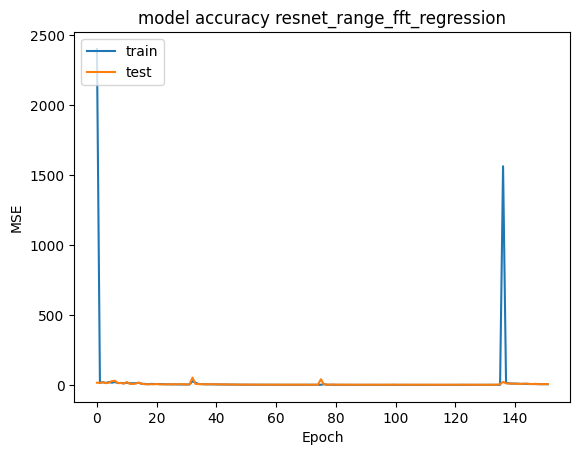

In [38]:
loss = tf.keras.losses.MeanSquaredError()
metrics = ['mae', 'mse']
model = Resnet_regression(filter_in = filter_in_list, filters = filter_out_list, kernel_size = kernel_size, out_nums=len(range_fft_dict))
# reg_Y_train, reg_Y_test = np.argmax(Y_train, axis = 1), np.argmax(Y_test, axis = 1)
history = train_regression(model = model, X = X_train, Y = np.argmax(Y_train, axis=1), test_X = X_test, test_Y = np.argmax(Y_test, axis=1), cp_path = 'resnet_range_fft_regression', Epoch=500, loss = loss, metrics = metrics, monitor='val_mse', mode='min')